In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import vis_tool
import torch
from torch.utils.data import TensorDataset

In [ ]:
def load_kth(root, batch_size, val_batch_size, num_workers, freq, strides, current, height, width):
    path = os.path.join(root, 'kth/')
    class_list = os.listdir(path)
    data = list()
    for fname in class_list:
        fpath = path + fname
        flist = list(os.listdir(fpath))
        for video in flist:
            img_path = fpath + '/' + video
            capture = capture_video(img_path, freq, strides, current, height, width)
            data.append(capture)
        print(f'{fname}: {len(flist)}', end=' ')
    
    # Print Video Config
    print()
    config_video = cv2.VideoCapture(img_path)
    print_vidcap_info(config_video)
    
    # Normalization & shuffle dataset
    dataset = np.array(data) / 255.0
    np.random.shuffle(dataset)

    # [B, T, H, W, C] --> [B, T, C, H, W]
    dataset = np.swapaxes(dataset,2,4)
    dataset = np.swapaxes(dataset,3,4)
    dataset = torch.tensor(dataset)
    print(dataset.shape)
    dataloader_train, dataloader_validation, dataloader_test, mean, std = make_dataloader(
        dataset, batch_size, val_batch_size, num_workers
    )
    return dataloader_train, dataloader_validation, dataloader_test, mean, std

def capture_video(path, freq, strides, current=0, height=120, width=160):
    vidcap = cv2.VideoCapture(path)
    if current > 0 :
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, current)
    if height != 120 :
        vidcap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    if height != 160 :
        vidcap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    
    frames=[]
    for i in range(freq):
        for j in range(strides):
            success, image = vidcap.read()
        image = image[:,:,0]
        frames.append(image[:,:,np.newaxis])
    frames = np.array(frames)
    return frames

def video_capture(path, current=0, height=120, width=160):
    vidcap = cv2.VideoCapture(path)
    if current > 0 :
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, current)
    if height != 120 :
        vidcap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    if height != 160 :
        vidcap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    
    return vidcap

def print_vidcap_info(vid_cap):
    print('초당 프레임 수',vid_cap.get(cv2.CAP_PROP_FPS))
    print('height',vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print('width',vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print('총 프레임 수 :',vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('현재 프레임 번호 :',vid_cap.get(cv2.CAP_PROP_POS_FRAMES))
    print('노출 :',vid_cap.get(cv2.CAP_PROP_EXPOSURE))
    print('영상 길이 :', vid_cap.get(cv2.CAP_PROP_FRAME_COUNT) / vid_cap.get(cv2.CAP_PROP_FPS),'s' )
    print('프레임 당 시간 간격 :', 1 / vid_cap.get(cv2.CAP_PROP_FPS),'s')

def make_dataloader(dataset, batch_size, val_batch_size, num_workers):
    train_set = TensorDataset(dataset[:500,:10], dataset[:500,10:])
    test_set = TensorDataset(dataset[500:,:10], dataset[500:,10:])
    
    dataloader_train = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    dataloader_validation = torch.utils.data.DataLoader(
        test_set, batch_size=val_batch_size, pin_memory=True, num_workers=num_workers)
    dataloader_test = torch.utils.data.DataLoader(
        test_set, batch_size=val_batch_size, pin_memory=True, num_workers=num_workers)
    
    mean, std = 0, 1
    return dataloader_train, dataloader_validation, dataloader_test, mean, std


In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import vis_tool
import torch
from torch.utils.data import TensorDataset

In [ ]:
path = './data/'
dataname = 'kth/'
classname = 'boxing/'
folder_path = os.path.join(path, dataname)
class_path = os.path.join(folder_path, classname)
file_list = os.listdir(class_path)

In [38]:
a = np.load(folder_path + 'dataset.npz')
print(a['train_x'].shape)
print(a['train_y'].shape)

(500, 10, 1, 120, 160)
(500, 10, 1, 120, 160)


In [7]:
import os
from API import *

path = './data/'
dataname = 'kth/'
classname = 'boxing/'
folder_path = os.path.join(path, dataname)
class_path = os.path.join(folder_path, classname)
file_list = os.listdir(class_path)


In [2]:
data_root, batch_size, val_batch_size, num_workers, freq, strides, current, out_frame = path, 8, 8, 8, 20, 5, 0, 10, 'kth'
dataloader_train, dataloader_validation, dataloader_test, mean, std = dataloader.load_data(
    data_root, batch_size, val_batch_size, num_workers, freq, strides, current, out_frame, dataname=dataname)

ValueError: too many values to unpack (expected 8)

In [3]:
dataloader_train, dataloader_validation, dataloader_test, mean, std = load_kth(
    path, 8, 8, 8, 20, 5, 0, 120, 160)

boxing: 100 handclapping: 99 jogging: 100 handwaving: 100 walking: 100 running: 100 
초당 프레임 수 25.0
height 120.0
width 160.0
총 프레임 수 : 350.0
현재 프레임 번호 : 0.0
노출 : 0.0
영상 길이 : 14.0 s
프레임 당 시간 간격 : 0.04 s
torch.Size([599, 20, 1, 120, 160])


In [4]:
print(len(dataloader_train))
print(len(dataloader_validation))
print(len(dataloader_test))

63
13
13


In [7]:
a_std = dataloader_train.dataset[0][0].std()
a_mean = dataloader_train.dataset[0][0].mean()

In [11]:
a_std.numpy()

array(0.09097717)

In [8]:
train_x, train_y = next(iter(dataloader_train))
valid_x, valid_y = next(iter(dataloader_validation))
test_x, test_y = next(iter(dataloader_test))

In [7]:
print(train_x.shape, train_y.shape, train_x.mean(), train_y.mean())
print(valid_x.shape, valid_y.shape, valid_x.mean(), valid_y.mean())
print(test_x.shape, test_y.shape, test_x.mean(), test_y.mean())

torch.Size([8, 10, 1, 120, 160]) torch.Size([8, 10, 1, 120, 160]) tensor(0.6488, dtype=torch.float64) tensor(0.6449, dtype=torch.float64)
torch.Size([8, 10, 1, 120, 160]) torch.Size([8, 10, 1, 120, 160]) tensor(0.5479, dtype=torch.float64) tensor(0.5561, dtype=torch.float64)
torch.Size([8, 10, 1, 120, 160]) torch.Size([8, 10, 1, 120, 160]) tensor(0.5479, dtype=torch.float64) tensor(0.5561, dtype=torch.float64)


In [12]:
train_concat = torch.concat([train_x,train_y],1)

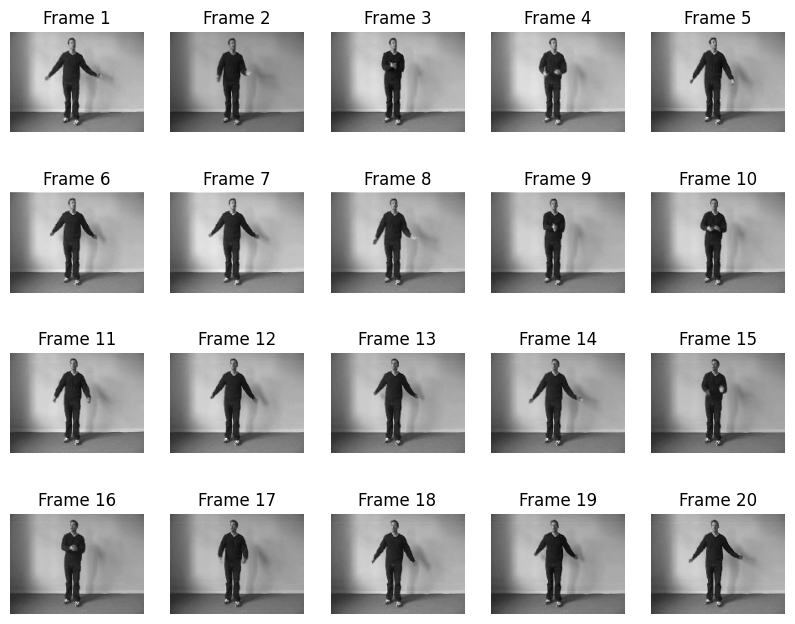

In [13]:
vis_tool.multi_frame(train_concat[3],path='',dataname='kth')

In [19]:
vid_sample = video_capture(class_path + file_list[0])
print_vidcap_info(vid_sample)

초당 프레임 수 25.0
height 120.0
width 160.0
총 프레임 수 : 302.0
현재 프레임 번호 : 0.0
노출 : 0.0
영상 길이 : 12.08 s
프레임 당 시간 간격 : 0.04 s


In [ ]:
success, image = vid_sample.read()
frames = np.array(image[:,:,0])
frames = 
frames.shape

In [28]:
a = image[:,:,0]
a[:,:,np.newaxis].shape

(120, 160, 1)

In [48]:
video = capture_video(class_path + file_list[0], 20, 5)
video = np.swapaxes(video,1,3)
video.shape

(20, 1, 160, 120)

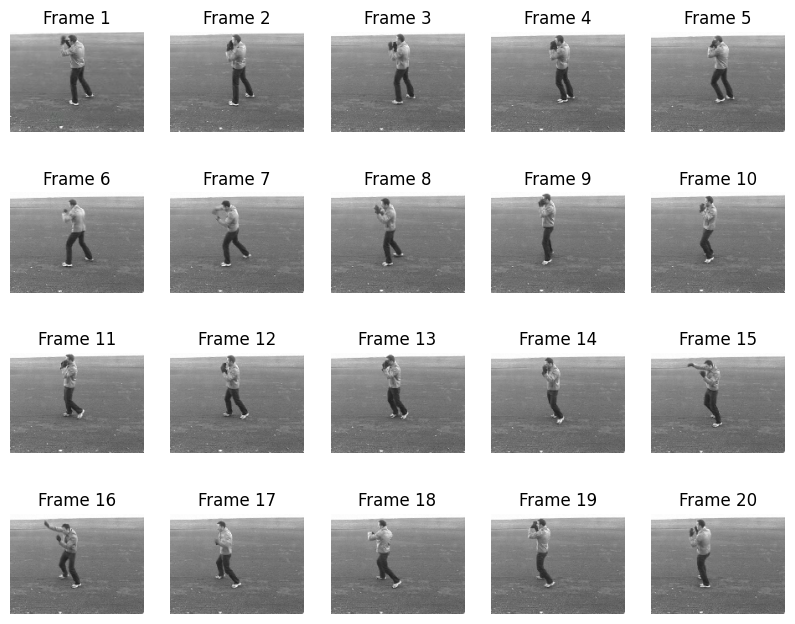

In [47]:
vis_tool.multi_frame(np.swapaxes(video,1,3)[:,:,:],path='',dataname='kth')

In [45]:
import torch
from torch.utils.tensorboard import SummaryWriter
path = './results/debug/tensorboard_logs'
writer = SummaryWriter(path)

In [44]:
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        # tensorboard add scalar
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()
writer.close()

In [93]:
import os
import argparse
import numpy as np
import cv2
from skimage.transform import resize

import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset
from utils import print_log
from vis_tool import *

In [55]:
def load_data(root, batch_size, val_batch_size, num_workers, out_frame):
    path = os.path.join(root, 'caltech/')
    train_dataset = np.load(path + 'dataset1Train.npz')
    test_dataset = np.load(path + 'dataset1Test.npz')

    train_x = train_dataset['x'].swapaxes(2,4).swapaxes(3,4)
    train_y = train_dataset['y'].swapaxes(2,4).swapaxes(3,4)
    test_x = test_dataset['x'].swapaxes(2,4).swapaxes(3,4)
    test_y = test_dataset['y'].swapaxes(2,4).swapaxes(3,4)
    
    train_x, train_y = torch.FloatTensor(train_x), torch.FloatTensor(train_x)
    test_x, test_y = torch.FloatTensor(test_x), torch.FloatTensor(test_y)
    
    train_mean = torch.concat([train_x,train_y],axis=1).mean()
    train_std = torch.concat([train_x,train_y],axis=1).std()
    test_mean = torch.concat([test_x,test_y],axis=1).mean()
    test_std = torch.concat([test_x,test_y],axis=1).std()


    train_set = TensorDataset(train_x, train_y)
    test_set = TensorDataset(test_x, test_y)

    # make dataloader
    dataloader_train, dataloader_validation, dataloader_test, mean, std = make_dataloader(
        train_set, test_set, batch_size, val_batch_size, num_workers, out_frame
    )
    return dataloader_train, dataloader_validation, dataloader_test, train_mean, train_std, test_mean, test_std


def make_dataloader(train_set, test_set, batch_size, val_batch_size, num_workers, out_frame):
    
    dataloader_train = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    dataloader_validation = torch.utils.data.DataLoader(
        test_set, batch_size=val_batch_size, pin_memory=True, num_workers=num_workers)
    dataloader_test = torch.utils.data.DataLoader(
        test_set, batch_size=val_batch_size, pin_memory=True, num_workers=num_workers)
    
    mean, std = 0, 1
    return dataloader_train, dataloader_validation, dataloader_test, mean, std

In [56]:
dataloader_train, dataloader_validation, dataloader_test, mean, std = load_data('./data', 8, 4, 8, 1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 1

In [99]:
dataset = np.load('./data/caltech/dataset3Train.npz')
x, y = dataset['x'], dataset['y']
print(x.shape, y.shape)

(287, 10, 128, 160, 3) (287, 10, 128, 160, 3)


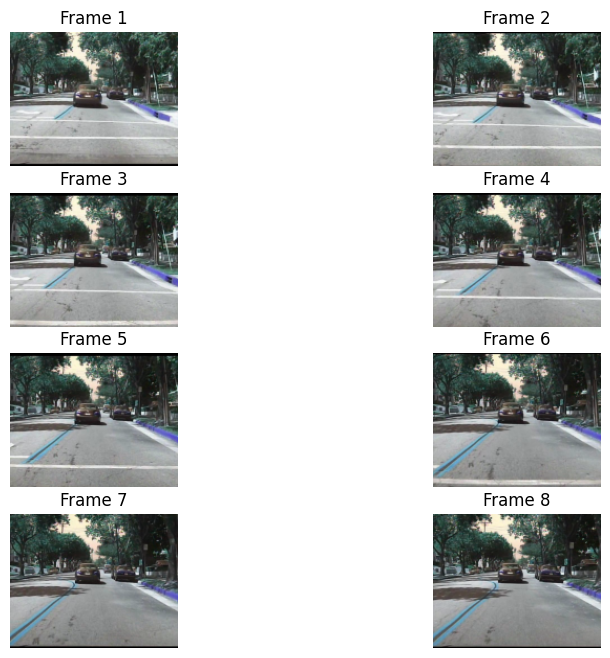

In [112]:
multi_frame(x[5])

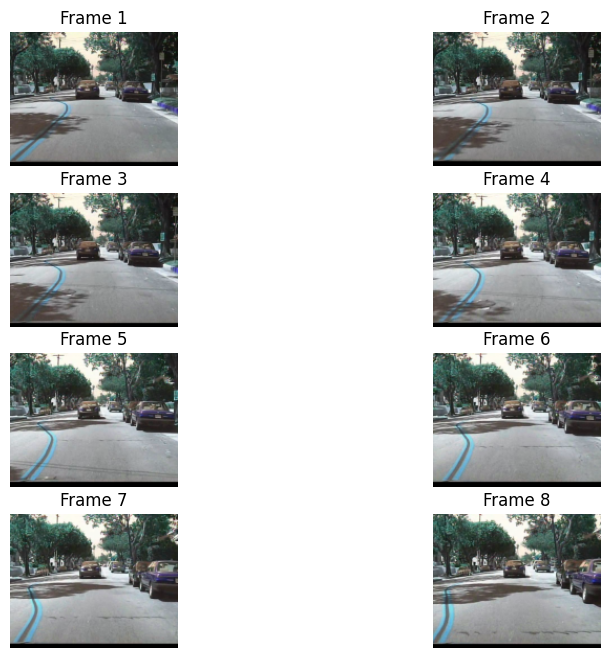

In [113]:
multi_frame(y[5])

In [ ]:
plt.imshow()

In [76]:
x, y = torch.FloatTensor(x), torch.FloatTensor(y)

In [82]:
torch.stack([x,y],axis=1).mean()

RuntimeError: stack expects each tensor to be equal size, but got [218, 10, 3, 128, 160] at entry 0 and [218, 1, 3, 128, 160] at entry 1

In [92]:
a = torch.concat([x,y],dim=1).mean()
a.item()

0.4246958792209625

In [63]:
y.mean()

tensor(0.4242)

In [61]:
(x+y).mean()

tensor(0.8490)

In [46]:
print(len(dataloader_train.dataset))
print(len(np.array(dataloader_train.dataset[0])))
print(len(dataloader_train.dataset[0][0]))

218


/tmp/ipykernel_2680689/2466563927.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(len(np.array(dataloader_train.dataset[0])))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [50]:
np.array(dataloader_train.dataset[0])

/tmp/ipykernel_2680689/249039047.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(dataloader_train.dataset[0])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

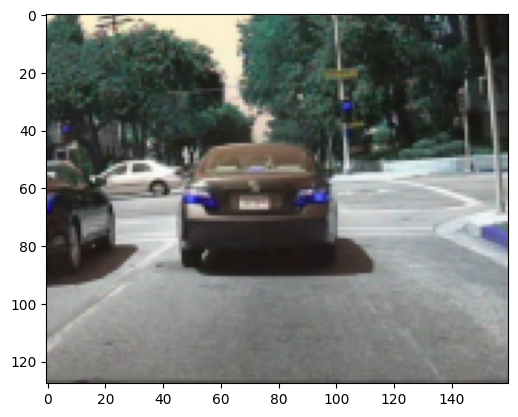

In [5]:
plt.imshow(x[0,0])
plt.show()

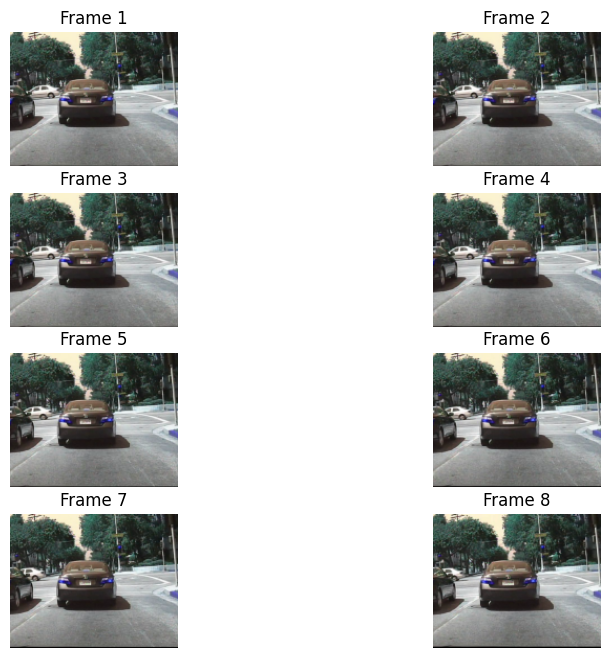

In [3]:
multi_frame(x[0], dataname='caltech')